<a href="https://colab.research.google.com/github/charlesbloomer/DNSC6301-Group-23/blob/main/DNSC_6301_Group_23_Project_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MIT License

Copyright (c) 2021 chengruichr

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.


#### Pythons imports

In [36]:
from sklearn import tree                             # sklearn tree model for decision trees
from sklearn.model_selection import train_test_split # for partitioning data
from sklearn.model_selection import cross_val_score  # for cross validation
from sklearn.metrics import roc_auc_score            # to asses decision tree perforamce

# to upload local files
import io
from google.colab import files             

import numpy as np                                   # array, vector, matrix calculations
import pandas as pd                                  # dataFrame handling

from matplotlib import pyplot as plt                 # plotting
import seaborn as sns                                # slightly better plotting  

SEED = 13579                                         # ALWAYS use a random seed for better reproducibility

In [37]:
import sklearn
sklearn.__version__

'0.22.2.post1'

#### Upload training data

In [38]:
# special google colab command to upload a file from your computer
uploaded = files.upload()

Saving credit_line_increase(1).csv to credit_line_increase(1) (1).csv


In [39]:
type(uploaded) # what kind of Python object did we just create?

dict

In [40]:
uploaded.keys() # what is stored in that Python object?

dict_keys(['credit_line_increase(1).csv'])

In [41]:
# read uploaded data into a pandas dataframe
data = pd.read_csv(io.StringIO(uploaded['credit_line_increase(1).csv'].decode('utf-8')))

#### Data Dictionary

| Name | Modeling Role | Measurement Level| Description|
| ---- | ------------- | ---------------- | ---------- |
|**ID**| ID | int | unique row indentifier |
| **LIMIT_BAL** | input | float | amount of previously awarded credit |
| **SEX** | demographic information | int | 1 = male; 2 = female
| **RACE** | demographic information | int | 1 = hispanic; 2 = black; 3 = white; 4 = asian |
| **EDUCATION** | demographic information | int | 1 = graduate school; 2 = university; 3 = high school; 4 = others |
| **MARRIAGE** | demographic information | int | 1 = married; 2 = single; 3 = others |
| **AGE** | demographic information | int | age in years |
| **PAY_0, PAY_2 - PAY_6** | inputs | int | history of past payment; PAY_0 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; ...; PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above |
| **BILL_AMT1 - BILL_AMT6** | inputs | float | amount of bill statement; BILL_AMNT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; ...; BILL_AMT6 = amount of bill statement in April, 2005 |
| **PAY_AMT1 - PAY_AMT6** | inputs | float | amount of previous payment; PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; ...; PAY_AMT6 = amount paid in April, 2005 |
| **DELINQ_NEXT**| target | int | whether a customer's next payment is delinquent (late), 1 = late; 0 = on-time |

#### Basic Data Analysis

In [42]:
data.shape # (rows, columns)

(30000, 26)

In [43]:
data.columns # names of columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'DELINQ_NEXT'],
      dtype='object')

In [44]:
data.isnull().any() # check for missing values

ID             False
LIMIT_BAL      False
SEX            False
RACE           False
EDUCATION      False
MARRIAGE       False
AGE            False
PAY_0          False
PAY_2          False
PAY_3          False
PAY_4          False
PAY_5          False
PAY_6          False
BILL_AMT1      False
BILL_AMT2      False
BILL_AMT3      False
BILL_AMT4      False
BILL_AMT5      False
BILL_AMT6      False
PAY_AMT1       False
PAY_AMT2       False
PAY_AMT3       False
PAY_AMT4       False
PAY_AMT5       False
PAY_AMT6       False
DELINQ_NEXT    False
dtype: bool

In [45]:
data.describe() # basic descriptive statistics

ID       LIMIT_BAL  ...       PAY_AMT6   DELINQ_NEXT
count  30000.000000    30000.000000  ...   30000.000000  30000.000000
mean   15000.500000   167484.322667  ...    5215.502567      0.221200
std     8660.398374   129747.661567  ...   17777.465775      0.415062
min        1.000000    10000.000000  ...       0.000000      0.000000
25%     7500.750000    50000.000000  ...     117.750000      0.000000
50%    15000.500000   140000.000000  ...    1500.000000      0.000000
75%    22500.250000   240000.000000  ...    4000.000000      0.000000
max    30000.000000  1000000.000000  ...  528666.000000      1.000000

[8 rows x 26 columns]

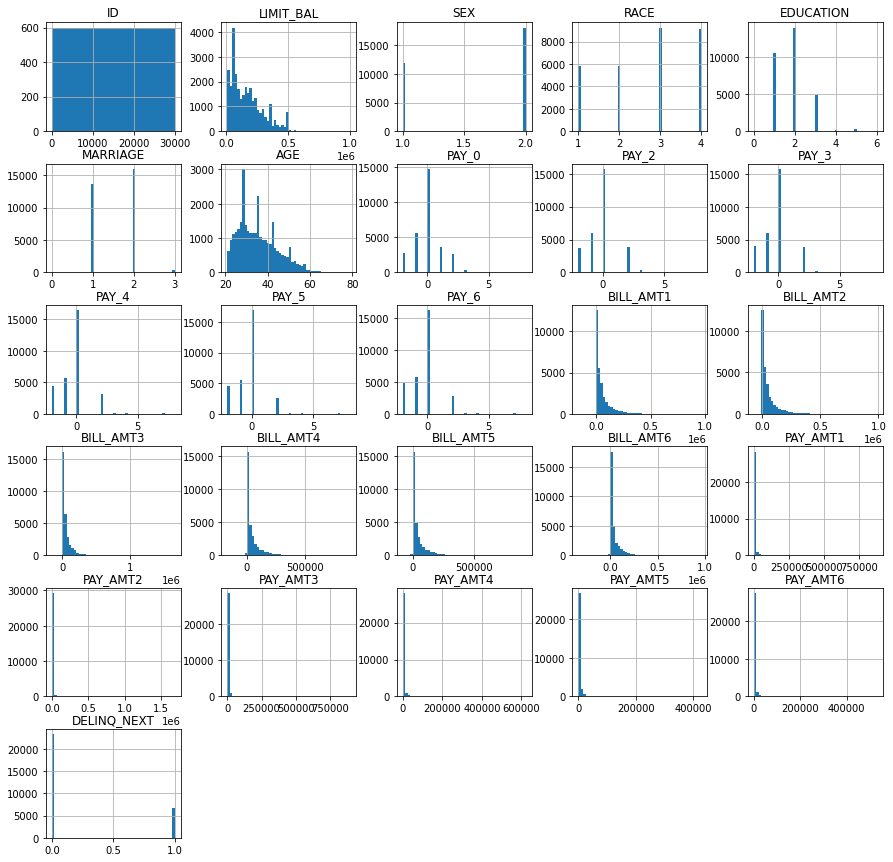

In [46]:
_ = data[data.columns].hist(bins=50, figsize=(15, 15)) # display histograms

In [47]:
# Pearson correlation matrix
corr = data.corr() 
corr

ID  LIMIT_BAL       SEX  ...  PAY_AMT5  PAY_AMT6  DELINQ_NEXT
ID           1.000000   0.026179  0.018497  ...  0.000652  0.003000    -0.013952
LIMIT_BAL    0.026179   1.000000  0.024755  ...  0.217202  0.219595    -0.153520
SEX          0.018497   0.024755  1.000000  ... -0.001667 -0.002766    -0.039961
RACE        -0.000710   0.044173  0.006149  ...  0.022148  0.020259    -0.303811
EDUCATION    0.039177  -0.219161  0.014232  ... -0.040358 -0.037200     0.028006
MARRIAGE    -0.029079  -0.108139 -0.031389  ... -0.001205 -0.006641    -0.024339
AGE          0.018678   0.144713 -0.090874  ...  0.022850  0.019478     0.013890
PAY_0       -0.030575  -0.271214 -0.057643  ... -0.058190 -0.058673     0.324794
PAY_2       -0.011215  -0.296382 -0.070771  ... -0.037093 -0.036500     0.263551
PAY_3       -0.018494  -0.286123 -0.066096  ... -0.035863 -0.035861     0.235253
PAY_4       -0.002735  -0.267460 -0.060173  ... -0.033590 -0.026565     0.216614
PAY_5       -0.022199  -0.249411 -0.055064  ... -0.033337 -0.023027     0.204149
PAY_6       -0.020270  -0.235195 -0.044008  ... -0.046434 -0.025299     0.186866
BILL_AMT1    0.019389   0.285430 -0.033642  ...  0.167026  0.179341    -0.019644
BILL_AMT2    0.017982   0.278314 -0.031183  ...  0.157957  0.174256    -0.014193
BILL_AMT3    0.024354   0.283236 -0.024563  ...  0.179712  0.182326    -0.014076
BILL_AMT4    0.040351   0.293988 -0.021880  ...  0.160433  0.177637    -0.010156
BILL_AMT5    0.016705   0.295562 -0.017005  ...  0.141574  0.164184    -0.006760
BILL_AMT6    0.016730   0.290389 -0.016733  ...  0.307729  0.115494    -0.005372
PAY_AMT1     0.009742   0.195236 -0.000242  ...  0.148459  0.185735    -0.072929
PAY_AMT2     0.008406   0.178408 -0.001391  ...  0.180908  0.157634    -0.058579
PAY_AMT3     0.039151   0.210167 -0.008597  ...  0.159214  0.162740    -0.056250
PAY_AMT4     0.007793   0.203242 -0.002229  ...  0.151830  0.157834    -0.056827
PAY_AMT5     0.000652   0.217202 -0.001667  ...  1.000000  0.154896    -0.055124
PAY_AMT6     0.003000   0.219595 -0.002766  ...  0.154896  1.000000    -0.053183
DELINQ_NEXT -0.013952  -0.153520 -0.039961  ... -0.055124 -0.053183     1.000000

[26 rows x 26 columns]

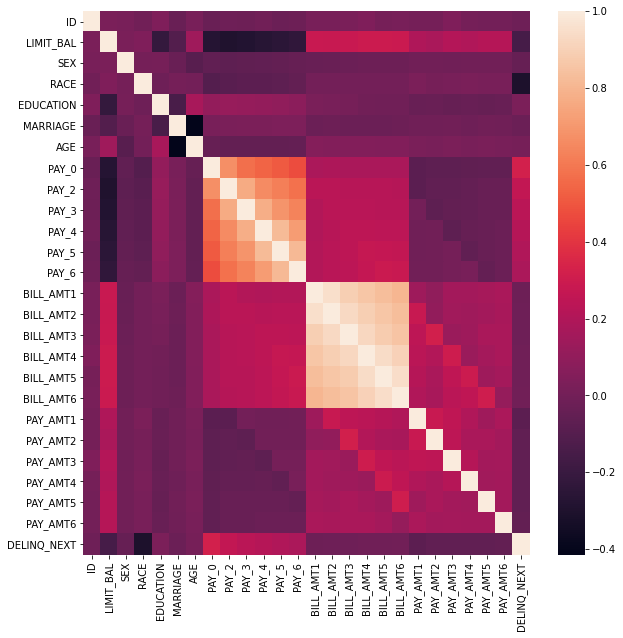

In [48]:
# correlation heatmap
plt.figure(figsize=(10, 10))
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

#### Train decision tree 

In [49]:
# assign basic modeling roles
# do not put demographic variables into a financial model!
y_name = 'DELINQ_NEXT'
X_names = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [50]:
# partition data for honest assessment
train_X, valid_test_X, train_y, valid_test_y = train_test_split(data[X_names], data[y_name], test_size=0.5, random_state=SEED) # split off training data
valid_X, test_X, valid_y, test_y = train_test_split(valid_test_X, valid_test_y, test_size=0.5, random_state=SEED) # split remainder into validation and test

# summarize 
print('Training data: %i rows and %i columns' % (train_X.shape[0], train_X.shape[1] + 1))
print('Validation data: %i rows and %i columns' % (valid_X.shape[0], valid_X.shape[1] + 1))
print('Testing data: %i rows and %i columns' % (test_X.shape[0], test_X.shape[1] + 1))

# housekeeping
del valid_test_X 
del valid_test_y

Training data: 15000 rows and 20 columns
Validation data: 7500 rows and 20 columns
Testing data: 7500 rows and 20 columns


In [51]:
# Train decision tree with validation-based early stopping
max_depth = 12
candidate_models = {}

# cycle through tree depths to find best model
for depth in range(0, max_depth):

  # fit a model at max_depth = depth+1
  clf = tree.DecisionTreeClassifier(max_depth = depth + 1, random_state=SEED)
  clf.fit(train_X, train_y)

  # score training and validation data
  train_phat = clf.predict_proba(train_X)[:, 1]
  valid_phat = clf.predict_proba(valid_X)[:, 1]

  # calculate AUC to assess performance quality
  train_auc = roc_auc_score(train_y, train_phat)
  valid_auc = roc_auc_score(valid_y, valid_phat)

  # calculate cross validation scores to assess stability
  cv_scores = cross_val_score(clf, valid_X, valid_y, scoring='roc_auc', cv=5)
  cv_std = np.std(cv_scores)

  # store results to analyze and select best model
  candidate_models[depth + 1] = {}
  candidate_models[depth + 1]['Model'] = clf
  candidate_models[depth + 1]['Training AUC'] = train_auc
  candidate_models[depth + 1]['Validation AUC'] = valid_auc
  candidate_models[depth + 1]['5-Fold SD'] = cv_std

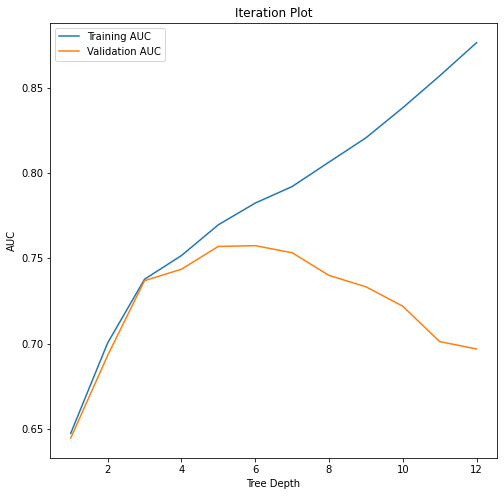

In [52]:
# Plot tree depth vs. training and validation AUC 
# using simple pandas plotting and matplotlib
candidate_results = pd.DataFrame.from_dict(candidate_models, orient='index')
fig, ax = plt.subplots(figsize=(8, 8))
_ = candidate_results[['Training AUC', 'Validation AUC']].plot(title='Iteration Plot',ax=ax)
_ = ax.set_xlabel('Tree Depth')
_ = ax.set_ylabel('AUC')


In [53]:
 # View same results as a table, using pandas iloc to remove first column of table
candidate_results.iloc[:, 1:]

Training AUC  Validation AUC  5-Fold SD
1       0.647369        0.644597   0.016798
2       0.700310        0.693018   0.012602
3       0.737671        0.736834   0.015641
4       0.751546        0.743541   0.013193
5       0.769572        0.756897   0.012789
6       0.782308        0.757357   0.012353
7       0.791989        0.753230   0.015534
8       0.806311        0.739920   0.016641
9       0.820533        0.733264   0.018589
10      0.838192        0.721864   0.027044
11      0.856870        0.701134   0.026183
12      0.876320        0.696804   0.023302

In [54]:
# From the above candidate results, we select final depth=6 to plot the decision tree
# plot the tree for human interpretation
best_model = candidate_models[6]['Model']
fig = plt.figure(figsize=(400, 70))
_ = tree.plot_tree(best_model,
                   feature_names=X_names,
                   class_names=['On time', 'Delinquent'],
                   filled=True)


In [55]:
candidate_models[6]['Model']

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=13579, splitter='best')

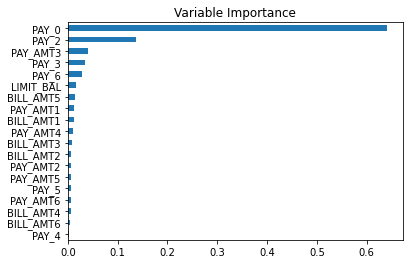

In [56]:
# plot variable importances
# create pandas dataframe
importances = pd.DataFrame(best_model.feature_importances_,
                           index=X_names,
                           columns=['Importance'])
# plot dataframe values
_ = importances.sort_values(by='Importance').plot(kind='barh', title='Variable Importance', legend=False)

In [57]:
# score on test data for 
# final HONEST assessment
# this is not to see how well the model *did*!
# it's to get an assessment of how it *will do* on unseen data!
test_phat = best_model.predict_proba(test_X)[:, 1]
print('Test AUC: %.4f' % roc_auc_score(test_y, test_phat))



Test AUC: 0.7407


#### Function to create confusion matrices

In [58]:
# function for confusion matrices
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])

    frame_ = frame.copy(deep=True)

    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)

    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]

    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]

    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))

    return cm_frame

#### Function to calculate AIR

In [59]:
# function for AIR
def air(cm_dict, reference_key, protected_key, verbose=True):

    eps = 1e-20

    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1])
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)

    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) 
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    return ((protected_prop + eps)/(reference_prop + eps))

#### Bias testing

In [60]:
# add probabilities onto validation set
# note we need a probability cutoff to make a final lending decision
valid_yhat = pd.DataFrame(valid_X, columns=X_names)
valid_yhat['RACE'] = data.loc[valid_yhat.index, 'RACE']
valid_yhat['SEX'] = data.loc[valid_yhat.index, 'SEX']
valid_yhat[y_name]  = valid_y
valid_yhat['phat'] = best_model.predict_proba(valid_X)[:, 1]
valid_yhat.head()

LIMIT_BAL  PAY_0  PAY_2  PAY_3  ...  RACE  SEX  DELINQ_NEXT      phat
25798     260000     -2     -2     -2  ...   4.0    2            1  0.195762
17034      10000      0      0      0  ...   4.0    2            1  0.150111
15514     520000     -1     -1     -1  ...   3.0    1            0  0.067251
3838       20000      0      0      0  ...   4.0    2            0  0.195762
6868       80000      0      0      0  ...   3.0    2            0  0.120219

[5 rows x 23 columns]

In [61]:
# calculate confusion matrices across race groups
# calculate confusion matrices at standard cutoff 0.15
# calculate AIR
race_dict = {'hispanic': 1,
             'black': 2,
             'white': 3,
             'asian': 4}

race_group_names = list(race_dict.keys())
race_cm_dict = {}

for name in race_group_names:
    race_cm_dict[name] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=race_dict[name], cutoff=0.15)
    print(race_cm_dict[name])
    print('(%s)' % name.title())
    print()

for name in race_group_names:
   if name != 'white':
      print('%s-to-%s AIR: %.2f' % (name, 'white', air(race_cm_dict, 'white', name)))
      print()

Confusion matrix by RACE=1
             actual: 1 actual: 0
predicted: 1       498       475
predicted: 0        95       393
(Hispanic)

Confusion matrix by RACE=2
             actual: 1 actual: 0
predicted: 1       462       479
predicted: 0       107       404
(Black)

Confusion matrix by RACE=3
             actual: 1 actual: 0
predicted: 1       211      1053
predicted: 0        44       975
(White)

Confusion matrix by RACE=4
             actual: 1 actual: 0
predicted: 1       213      1059
predicted: 0        35       997
(Asian)

White proportion accepted: 0.446
Hispanic proportion accepted: 0.334
hispanic-to-white AIR: 0.75

White proportion accepted: 0.446
Black proportion accepted: 0.352
black-to-white AIR: 0.79

White proportion accepted: 0.446
Asian proportion accepted: 0.448
asian-to-white AIR: 1.00



In [62]:
# calculate confusion matrices across sex groups
# calculate confusion matrices at standard cutoff 0.15
# calculate AIR
sex_dict = {'male': 1,
            'female': 2}

sex_group_names = list(sex_dict.keys())
sex_cm_dict = {}

for name in sex_group_names:
    sex_cm_dict[name] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='SEX', level=sex_dict[name], cutoff=0.15)
    print(sex_cm_dict[name])
    print('(%s)' % name.title())
    print()

for name in sex_group_names:
   if name != 'male':
      print('%s-to-%s AIR: %.2f' % (name, 'male', air(sex_cm_dict, 'male', name)))
      print()

Confusion matrix by SEX=1
             actual: 1 actual: 0
predicted: 1       600      1254
predicted: 0       118      1039
(Male)

Confusion matrix by SEX=2
             actual: 1 actual: 0
predicted: 1       784      1812
predicted: 0       163      1730
(Female)

Male proportion accepted: 0.384
Female proportion accepted: 0.422
female-to-male AIR: 1.10



#### Bias Remediation

In [63]:
# function to calculate accuracy at a certain probability cutoff
def get_acc(frame, cutoff, y_name, yhat_name):

  temp = frame.copy(deep=True) 
  temp['decision'] = np.where(temp[yhat_name] > cutoff , 1, 0)
  acc = accuracy_score(temp[y_name], temp['decision'])
  del temp
  return acc

In [64]:
# observe accuracy trend as cutoff increases
# the problem is: higher cutoff means lending more money, even if more accurate
from sklearn.metrics import accuracy_score
for cutoff in np.arange(0.1, 0.31, 0.01):
  print('Accuracy at cutoff %.2f is: %.4f' % (np.round(cutoff, 2), 
                                              get_acc(valid_yhat, np.round(cutoff, 2), y_name, 'phat')))   

Accuracy at cutoff 0.10 is: 0.4669
Accuracy at cutoff 0.11 is: 0.4669
Accuracy at cutoff 0.12 is: 0.4669
Accuracy at cutoff 0.13 is: 0.5537
Accuracy at cutoff 0.14 is: 0.5537
Accuracy at cutoff 0.15 is: 0.5537
Accuracy at cutoff 0.16 is: 0.7027
Accuracy at cutoff 0.17 is: 0.7027
Accuracy at cutoff 0.18 is: 0.7027
Accuracy at cutoff 0.19 is: 0.7027
Accuracy at cutoff 0.20 is: 0.7789
Accuracy at cutoff 0.21 is: 0.7933
Accuracy at cutoff 0.22 is: 0.7933
Accuracy at cutoff 0.23 is: 0.7933
Accuracy at cutoff 0.24 is: 0.7933
Accuracy at cutoff 0.25 is: 0.7936
Accuracy at cutoff 0.26 is: 0.7936
Accuracy at cutoff 0.27 is: 0.7936
Accuracy at cutoff 0.28 is: 0.7936
Accuracy at cutoff 0.29 is: 0.7964
Accuracy at cutoff 0.30 is: 0.7964


In [65]:
# recalculate AIR and confusion matrices at different cutoff=0.16
for name in race_group_names:
    race_cm_dict[name] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=race_dict[name], cutoff=0.16, verbose=False)

for name in race_group_names:
   if name != 'white':
      print('%s-to-%s AIR: %.2f' % (name, 'white', air(race_cm_dict, 'white', name)))
      print()

for name in sex_group_names:
    sex_cm_dict[name] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='SEX', level=sex_dict[name], cutoff=0.16, verbose=False)

for name in sex_group_names:
   if name != 'male':
      print('%s-to-%s AIR: %.2f' % (name, 'male', air(sex_cm_dict, 'male', name)))
      print()


White proportion accepted: 0.662
Hispanic proportion accepted: 0.537
hispanic-to-white AIR: 0.81

White proportion accepted: 0.662
Black proportion accepted: 0.543
black-to-white AIR: 0.82

White proportion accepted: 0.662
Asian proportion accepted: 0.690
asian-to-white AIR: 1.04

Male proportion accepted: 0.603
Female proportion accepted: 0.637
female-to-male AIR: 1.06



In [66]:
# redo model search with new information
# train decision tree 
# with validation-based early stopping
# and AIR calculation!
max_depth = 12
candidate_models = {}

for depth in range(0, max_depth):

  clf = tree.DecisionTreeClassifier(max_depth = depth + 1, random_state=SEED)
  clf.fit(train_X, train_y)

  train_phat = clf.predict_proba(train_X)[:, 1]
  valid_phat = clf.predict_proba(valid_X)[:, 1]

  train_auc = roc_auc_score(train_y, train_phat)
  valid_auc = roc_auc_score(valid_y, valid_phat)

  valid_yhat = pd.DataFrame(valid_X, columns=X_names)
  valid_yhat['RACE'] = data.loc[valid_yhat.index, 'RACE']
  valid_yhat[y_name] = valid_y
  valid_yhat['phat'] = valid_phat
  cm_dict = {}
  cm_dict['white'] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=3, cutoff=0.16, verbose=False)
  cm_dict['hispanic'] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=1, cutoff=0.16, verbose=False)
  valid_hispanic_air = air(cm_dict, 'white', 'hispanic', verbose=False)

  cv_scores = cross_val_score(clf, valid_X, valid_y, scoring='roc_auc', cv=5)
  cv_std = np.std(cv_scores)

  candidate_models[depth + 1] = {}
  candidate_models[depth + 1]['Model'] = clf
  candidate_models[depth + 1]['Training AUC'] = train_auc
  candidate_models[depth + 1]['Validation AUC'] = valid_auc
  candidate_models[depth + 1]['5-Fold SD'] = cv_std
  candidate_models[depth + 1]['Hispanic-to-White AIR'] = valid_hispanic_air


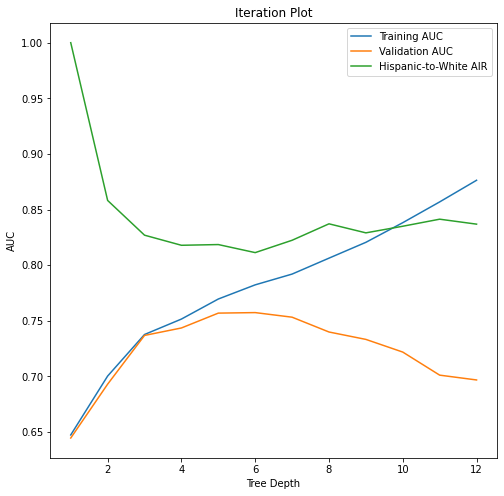

In [67]:
# plot tree depth vs. training and validation AUC and AIR
# using simple pandas plotting and matplotlib
candidate_results = pd.DataFrame.from_dict(candidate_models, orient='index')
fig, ax = plt.subplots(figsize=(8, 8))
_ = candidate_results[['Training AUC', 'Validation AUC', 'Hispanic-to-White AIR']].plot(title='Iteration Plot',
                                                                                        ax=ax)
_ = ax.set_xlabel('Tree Depth')
_ = ax.set_ylabel('AUC')

In [68]:
candidate_results.iloc[:, 1:]

Training AUC  Validation AUC  5-Fold SD  Hispanic-to-White AIR
1       0.647369        0.644597   0.016798               1.000000
2       0.700310        0.693018   0.012602               0.858178
3       0.737671        0.736834   0.015641               0.826958
4       0.751546        0.743541   0.013193               0.817877
5       0.769572        0.756897   0.012789               0.818520
6       0.782308        0.757357   0.012353               0.811285
7       0.791989        0.753230   0.015534               0.822381
8       0.806311        0.739920   0.016641               0.837160
9       0.820533        0.733264   0.018589               0.829040
10      0.838192        0.721864   0.027044               0.834992
11      0.856870        0.701134   0.026183               0.841334
12      0.876320        0.696804   0.023302               0.836872

In [69]:
best_model = candidate_models[6]['Model']
fig = plt.figure(figsize=(400, 70))
_ = tree.plot_tree(best_model,
                   feature_names=X_names,
                   class_names=['On time', 'Delinquent'],
                   filled=True)
